# Single Electrode Permuted Regressions
Created: 07/30/24 \
Updated: 07/30/2024 \
*Run for NYC Neuromod Conf

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08012024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

sns.set_theme(style='ticks') 
sns.set_context("poster")



In [8]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm


# saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# 671351
saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
saez_hex_cmap  = ListedColormap(saez_colors)
saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
#plot_palette = saez_linear_cmap.resampled(lutsize=30)
expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


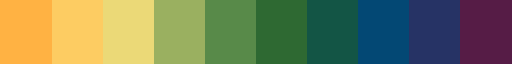

In [9]:
saez_full_cmap

# Load beta power data 

In [10]:
# #### Try Beta Power 
# all_subj_beta_power = {}
# all_subj_metadata   = {}

# beta_range = [13,30]

# # load pow epochs data 
# for subj_id in subj_ids: 
#     # load power epochs for single subject 
#     power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
#     all_subj_metadata[subj_id] = power_epochs.metadata.copy()
    
#     # extract power df with mean beta power for each epoch for each elec 
#     power_df = power_epochs.to_data_frame()
#     del power_epochs 
#     beta_power_df = power_df[(power_df.freq >= beta_range[0])&(power_df.freq <= beta_range[1])].groupby(['epoch']).agg('mean').reset_index()
#     del power_df 
#     all_subj_beta_power[subj_id] = beta_power_df
#     del beta_power_df
    
    
# # create a binary pickle file 
# pickle.dump(all_subj_beta_power,open(f'{save_dir}all_subj_beta_power_nocrop.pkl',"wb"))
# pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata.pkl',"wb"))

    

# Make Beta Regression DF

1. Update metadata vars - add t+1 vars, normalize vecs by 2std
2. Aggregate metadata, power data, ROI info, bdi info into one master df 

In [11]:
beta_df = pd.read_csv(f'{save_dir}beta_master_df.csv')
beta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [12]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [13]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [14]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=20].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
# keep_rois


In [15]:
####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
len(beta_reg_df)

244136

In [16]:
np.max(beta_reg_df.band_pow)

6.032583972049991

# Test Single Electrode Regressions 

In [17]:
beta_reg_df

,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,20.743342,beta,-0.123971,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,20.743342,beta,-0.186139,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,20.743342,beta,-0.235353,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,20.743342,beta,-0.086471,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,20.743342,beta,-0.145393,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258468,258468,DA039,22,rtp6-rtp7,DA039_rtp6-rtp7,148,20.743342,beta,-0.198057,temporal pole,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258469,258469,DA039,22,rtp7-rtp8,DA039_rtp7-rtp8,148,20.743342,beta,-0.240000,temporal pole,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,20.743342,beta,-0.199545,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258471,258471,DA039,22,rsgcc7-rsgcc8,DA039_rsgcc7-rsgcc8,148,20.743342,beta,-0.294459,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [ ]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(beta_df,reg_formula,elec_col, main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2288.45it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2588.02it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2663.07it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2716.74it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3145.45it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2358.58it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2501.68it/s]


Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

In [71]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialType[T.loss],Original_Estimate_TrialType[T.mix],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,...,Z_Score_TrialType[T.loss],Z_Score_TrialType[T.mix],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialType[T.loss],P_Value_TrialType[T.mix],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.043383,-0.034128,-0.036971,-0.031993,0.019482,0.032085,...,-1.240031,-1.048242,0.850864,1.539639,0.014798,0.199665,0.214964,0.294527,0.394845,0.123648
1,MS002_lacas2-lacas3,MS002,acc,14,0.001012,0.029915,-0.033398,-0.027601,0.014953,0.043316,...,-1.006292,-0.757444,0.534009,1.680336,0.976608,0.334435,0.314275,0.448784,0.593335,0.092892
2,MS002_lacas3-lacas4,MS002,acc,14,0.011883,-0.028383,-0.016342,0.038947,0.015163,0.042782,...,-0.544147,1.141545,0.584798,1.762675,0.548190,0.332338,0.586341,0.253643,0.558683,0.077955
3,MS002_lacas4-lacas5,MS002,acc,14,0.009771,-0.012740,-0.027905,-0.002515,-0.009457,0.041117,...,-1.005293,-0.063604,-0.484379,2.072035,0.279085,0.587433,0.314756,0.949285,0.628117,0.038262
4,MS002_lacas5-lacas6,MS002,acc,14,-0.007743,0.021737,-0.000402,-0.011713,-0.007985,-0.003162,...,-0.022749,-0.390240,-0.370620,-0.124807,0.551029,0.392542,0.981850,0.696359,0.710920,0.900676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,DA039_rtp6-rtp7,DA039,temporal pole,22,-0.087485,0.075957,-0.007011,-0.060854,-0.041262,0.007830,...,-0.172259,-1.497322,-1.323345,0.267025,0.758328,0.042559,0.863234,0.134309,0.185721,0.789450
1772,DA039_rtp7-rtp8,DA039,temporal pole,22,-0.099978,0.020006,-0.048231,-0.066053,0.010283,-0.017812,...,-1.249321,-1.796793,0.395090,-0.653656,0.103212,0.558765,0.211548,0.072368,0.692776,0.513334
1773,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.113685,0.029522,-0.042136,-0.005936,0.009859,0.056641,...,-0.685306,-0.100807,0.221909,1.234820,0.922611,0.587703,0.493151,0.919703,0.824384,0.216897
1774,DA039_rsgcc7-rsgcc8,DA039,vlpfc,22,-0.092450,-0.021220,0.036261,0.062786,-0.006308,0.117211,...,0.551277,0.923028,-0.150752,2.482470,0.457402,0.717448,0.581444,0.355993,0.880172,0.013048


In [32]:
main_var_sig

['MS002_lacas4-lacas5',
 'MS002_laims4-laims5',
 'MS002_lhplt9-lhplt10',
 'MS002_racas7-racas8',
 'MS002_raims1-raims2',
 'MS002_raims3-raims4',
 'MS003_laglt1-laglt2',
 'MS003_laimm10-laimm11',
 'MS003_lmcms4-lmcms5',
 'MS003_lmcms8-lmcms9',
 'MS003_lmolf1-lmolf2',
 'MS003_lsifo1-lsifo2',
 'MS003_racas3-racas4',
 'MS003_racas6-racas7',
 'MS003_raglt3-raglt4',
 'MS003_raglt7-raglt8',
 'MS003_raimm5-raimm6',
 'MS003_raimm6-raimm7',
 'MS003_raimm12-raimm13',
 'MS003_rmcms1-rmcms2',
 'MS009_lacas4-lacas5',
 'MS009_lhpit1-lhpit2',
 'MS009_lhpit8-lhpit9',
 'MS011_lagit3-lagit4',
 'MS011_lagit5-lagit6',
 'MS011_lmcps1-lmcps2',
 'MS011_lmcps7-lmcps8',
 'MS011_lmtpt5-lmtpt6',
 'MS011_rhpit5-rhpit6',
 'MS011_rins2-rins3',
 'MS011_rmolf5-rmolf6',
 'MS015_lmcms7-lmcms8',
 'MS016_lacas8-lacas9',
 'MS016_lagit8-lagit9',
 'MS016_laimm3-laimm4',
 'MS016_laimm12-laimm13',
 'MS016_racas8-racas9',
 'MS016_racas9-racas10',
 'MS016_racas10-racas11',
 'MS017_lalps11-lalps12',
 'MS017_lhplt8-lhplt9',
 'MS01

In [72]:
sig_data = results[results.P_Value_decisionCPE <= 0.05]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialType[T.loss],Original_Estimate_TrialType[T.mix],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,...,Z_Score_TrialType[T.loss],Z_Score_TrialType[T.mix],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialType[T.loss],P_Value_TrialType[T.mix],P_Value_TotalProfit,P_Value_decisionCPE
3,MS002_lacas4-lacas5,MS002,acc,14,0.009771,-0.012740,-0.027905,-0.002515,-0.009457,0.041117,...,-1.005293,-0.063604,-0.484379,2.072035,0.279085,0.587433,0.314756,0.949285,0.628117,0.038262
18,MS002_laims4-laims5,MS002,ains,14,-0.023332,0.050443,0.069151,-0.027850,0.045021,0.067890,...,1.724649,-0.690801,1.466648,2.205586,0.066669,0.162000,0.084591,0.489691,0.142472,0.027413
30,MS002_lhplt9-lhplt10,MS002,sts,14,-0.070720,0.059010,-0.039837,-0.034514,0.051722,-0.063788,...,-1.226877,-1.024116,1.893987,-2.516005,0.474583,0.059196,0.219869,0.305781,0.058227,0.011869
62,MS002_racas7-racas8,MS002,dmpfc,14,0.110753,-0.114386,0.085284,-0.060361,0.014129,-0.062875,...,2.073354,-1.344097,0.416522,-1.972245,0.011554,0.003964,0.038139,0.178917,0.677028,0.048582
72,MS002_raims1-raims2,MS002,ains,14,0.116633,-0.078484,0.019070,-0.108658,0.025521,0.104976,...,0.357499,-1.948538,0.627697,2.727581,0.012901,0.099385,0.720719,0.051351,0.530202,0.006380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,DA037_rmins1-rmins2,DA037,pins,4,-0.143436,0.049007,0.023030,0.009310,-0.019629,0.092214,...,0.618170,0.251562,-0.713572,3.294215,0.281495,0.197853,0.536463,0.801380,0.475492,0.000987
1745,DA039_rpmot4-rpmot5,DA039,motor,22,-0.049683,0.072537,-0.050541,-0.034794,0.073533,-0.074417,...,-1.026860,-0.773640,2.085891,-2.163785,0.954446,0.081564,0.304486,0.439143,0.036988,0.030481
1754,DA039_rof8-rof9,DA039,dlpfc,22,-0.078551,0.014137,0.002478,-0.012637,0.097324,0.082606,...,0.059136,-0.228149,2.133616,1.973211,0.964460,0.802439,0.952844,0.819531,0.032874,0.048472
1755,DA039_rof9-rof10,DA039,dlpfc,22,-0.062588,0.039495,-0.066049,-0.050133,0.046225,0.088322,...,-1.139001,-0.870049,1.042956,2.097756,0.467787,0.429392,0.254703,0.384274,0.296969,0.035927


In [80]:
sig_data.roi.value_counts()['ains']

8

In [85]:
sig_data[sig_data.roi=='ains']

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialType[T.loss],Original_Estimate_TrialType[T.mix],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,...,Z_Score_TrialType[T.loss],Z_Score_TrialType[T.mix],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialType[T.loss],P_Value_TrialType[T.mix],P_Value_TotalProfit,P_Value_decisionCPE
18,MS002_laims4-laims5,MS002,ains,14,-0.023332,0.050443,0.069151,-0.027850,0.045021,0.067890,...,1.724649,-0.690801,1.466648,2.205586,0.066669,0.162000,0.084591,0.489691,0.142472,0.027413
72,MS002_raims1-raims2,MS002,ains,14,0.116633,-0.078484,0.019070,-0.108658,0.025521,0.104976,...,0.357499,-1.948538,0.627697,2.727581,0.012901,0.099385,0.720719,0.051351,0.530202,0.006380
74,MS002_raims3-raims4,MS002,ains,14,0.113351,-0.058948,0.021380,-0.107637,-0.013362,0.105669,...,0.445733,-2.052713,-0.343756,2.833213,0.034324,0.199027,0.655790,0.040100,0.731030,0.004608
833,MS028_laips1-laips2,MS028,ains,13,0.025722,-0.116306,0.185938,0.172493,0.044553,0.093473,...,2.516447,2.990898,0.963420,2.147111,0.024564,0.057527,0.011854,0.002782,0.335337,0.031784
920,MS029_lais1-lais2,MS029,ains,32,-0.009428,-0.029000,0.003656,0.081544,-0.080969,-0.077825,...,0.073222,2.056623,-2.535304,-2.462021,0.588527,0.374490,0.941629,0.039722,0.011235,0.013816
1063,MS030_lsipt1-lsipt2,MS030,ains,19,0.012977,-0.087097,0.081277,0.008044,0.020795,-0.066996,...,2.579991,0.180665,0.797026,-2.585206,0.874608,0.006377,0.009880,0.856631,0.425436,0.009732
1520,MS050_lainss5-lainss6,MS050,ains,9,-0.006714,0.057311,0.015457,0.006326,0.014745,0.058803,...,0.401497,0.138852,0.443338,2.052617,0.110891,0.083949,0.688054,0.889567,0.657521,0.040110
1558,MS050_rainss3-rainss4,MS050,ains,9,0.095022,-0.055810,0.030243,-0.040254,-0.046761,0.163140,...,0.527030,-0.695191,-1.033176,3.863625,0.331410,0.243531,0.598173,0.486936,0.301522,0.000112


In [79]:
sig_data.subj_id.value_counts()

MS003    14
MS035    10
MS029    10
MS050    10
MS041     9
MS030     8
MS033     8
MS027     8
MS043     7
MS016     7
MS048     7
MS002     6
MS026     6
MS011     6
MS024     6
DA039     4
MS019     4
MS028     4
DA026     4
MS009     3
DA037     3
MS017     3
MS022     2
MS025     1
MS015     1
DA8       1
DA023     1
Name: subj_id, dtype: int64